In [183]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from matplotlib import pyplot as plt


sys.path.insert(0, "..") 
from src.data import make_dataset
from src.features import build_features
from src.visualization import visualize

pd.set_option("display.precision", 5)
pd.set_option("display.max.columns", None)
pd.options.display.float_format = '{:6.5f}'.format

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Bonds

In dit onderzoek is uitgegaan van een beperkte set bonds. Het is nog onduidelijk of de data van verlopen bonds ook zinvol is voor het onderzoek. Een bond is typisch maar kort in portefeuille waardoor we geen lange tijdreeksen hebben van een bepaalde bond. Mogelijk komt de bond wel erg over een met andere bonds die we in het verleden hebben gehad en zegt het koerstverloop van die bonds iets over het koersverloop van de huidige bonds. Mogelijk spelen benchmark bonds hier een rol bij. 

In [184]:
df_bonds = make_dataset.read_pkl('bonds')

2022-01-16 16:40:56.775 | INFO     | src.data.make_dataset:read_pkl:382 - Load preprocessed bonds data


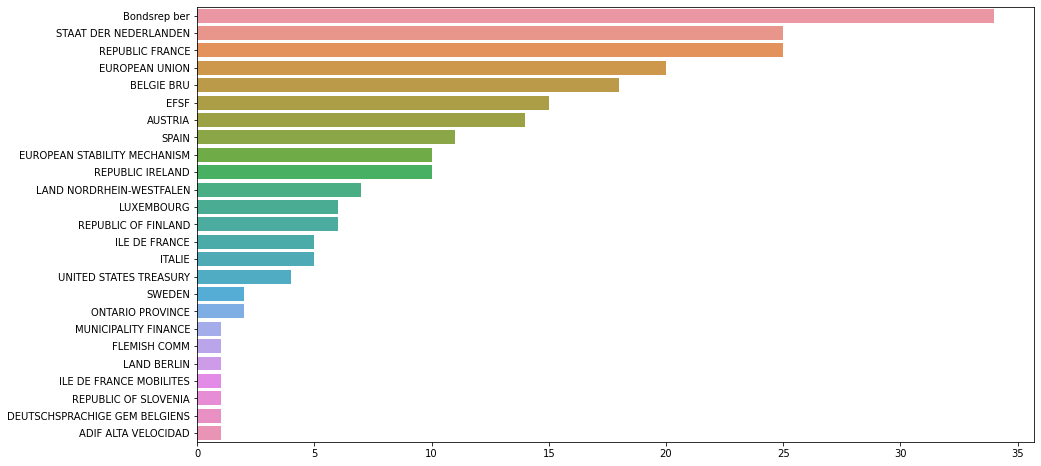

In [185]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'issuer_name')

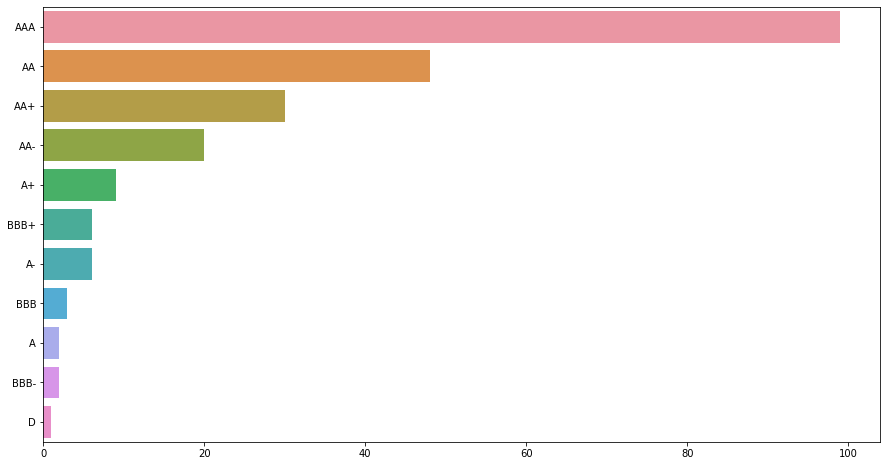

In [186]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'issue_rating')

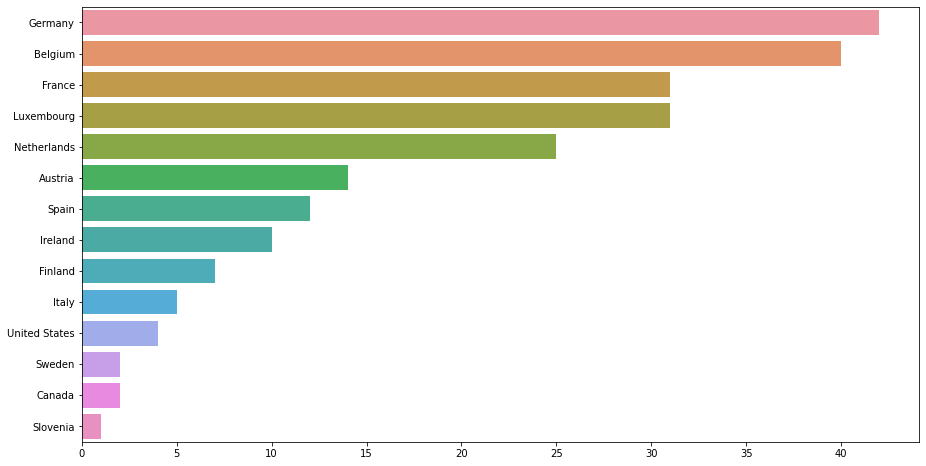

In [187]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'country')

Bond prices

In [188]:
df_price = make_dataset.read_pkl('price')
df_price.head()

2022-01-16 16:40:58.073 | INFO     | src.data.make_dataset:read_pkl:382 - Load preprocessed price data


,reference_identifier,ccy,rate_dt,mid,lastday
0,DE0001135143,EUR,2010-12-17,136.76000,2010-12-31
1,NL0000102275,EUR,2010-12-17,103.39000,2010-12-31
2,DE0001135424,EUR,2010-12-17,95.45300,2010-12-31
3,NL0009446418,EUR,2010-12-17,102.69000,2010-12-31
4,NL0000102234,EUR,2010-12-17,106.22000,2010-12-31


Voor het onderzoek richten we ons in eerste instantie op Nederlandse staatsobligaties met een looptijd van 10 jaar. Voor bijna ieder jaar is er een uitgifte van een 10 jaars vastrente obligatie. Wanneer we kijken naar bonds met een zelfde looptijd, en zelfde issuer, dan zien we dat de term spread langzaam afneemt. Naar mate de maturity dichterbij komt wordt de prijs steeds meer bepaald door de resterende looptijd.

2022-01-16 17:06:04.221 | INFO     | src.data.make_dataset:read_pkl:382 - Load preprocessed bp data


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

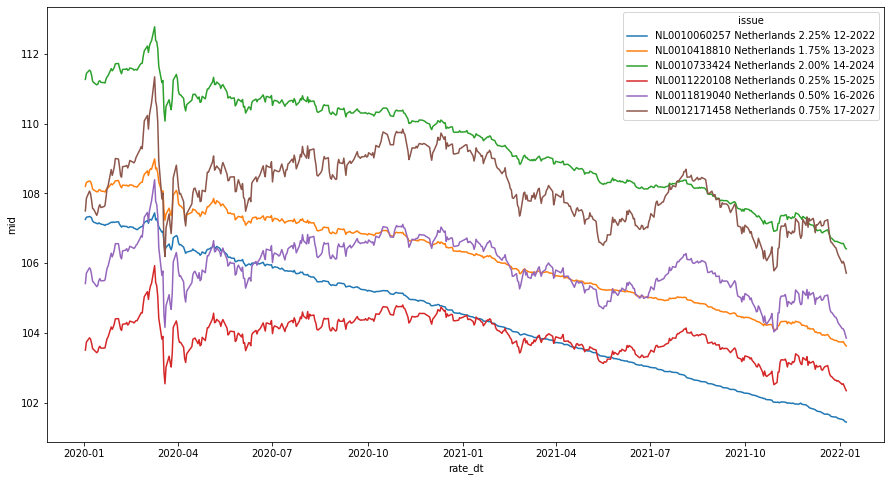

In [231]:
# isin = "NL0011220108" # 10 Years NL Bond, maturity 2025 0.25% coupon
import datetime 
df_bp = make_dataset.read_pkl('bp')
df_bp['issue'] = df_bp['reference_identifier'] + ' ' +  df_bp['country'] + ' ' + df_bp['bond_ext_name'].str.split(n=1).str[1]
df_bp =df_bp.assign(interest = pd.cut(df_bp["coupon"], [-1,0.001,1,2,3,4,5,10], 
                        labels=['0%', '< 1%', '1 - 2%','2 - 3%', '3 - 4%','4 - 5%', '5% >']))

df_bp_10y = df_bp.loc[( df_bp['bond_duration'] > 3650 ) & ( df_bp['bond_duration'] < 4000 )]
df_bp_10y = df_bp_10y.sort_values( by = ['country','mature_dt'] )

filter =    ( df_bp_10y['country'] == 'Netherlands' ) & \
            ( df_bp_10y['coupon'] > 0 ) & \
            ( df_bp_10y['mature_dt'] > '1-jan-2022' ) & \
            ( df_bp_10y['mature_dt'] < '1-jan-2028' ) & \
            ( df_bp_10y['rate_dt'] > '1-jan-2020' )       
df_nl_10y = df_bp_10y.loc[filter]

plt.figure(figsize=(15,8))
sns.lineplot(data = df_nl_10y, x = 'rate_dt', y = 'mid', hue = 'issue')


We zien dat de bond prijs gerelateerd is aan de hoogte van de coupon en de resterende looptijd. 
We zien bij alle bonds dat de prijs de laatste 5 jaar ongeveer gelijkmatig terugloopt naar 100 naarmate de eind datum van de bond dichterbij komt.

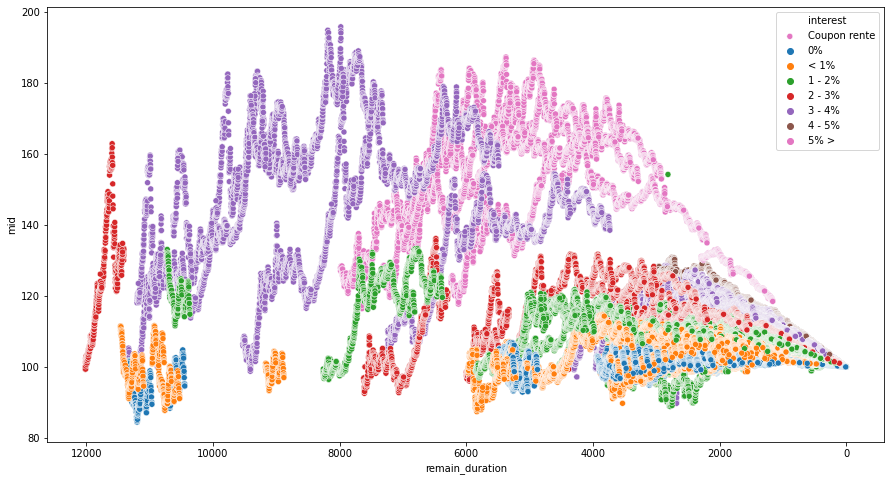

In [235]:
plt.figure(figsize=(15,8))

df_bp =df_bp.assign(bins = pd.cut(df_bp["coupon"], [-1,0.001,1,2,3,4,5,10], 
                        labels=['0%', '< 1%', '1 - 2%','2 - 3%', '3 - 4%','4 - 5%', '5% >']))
ax = sns.scatterplot(data = df_bp, x = 'remain_duration', y = 'mid', hue = 'interest', label = 'Coupon rente')
ax.invert_xaxis()

<AxesSubplot:xlabel='bins', ylabel='mid'>

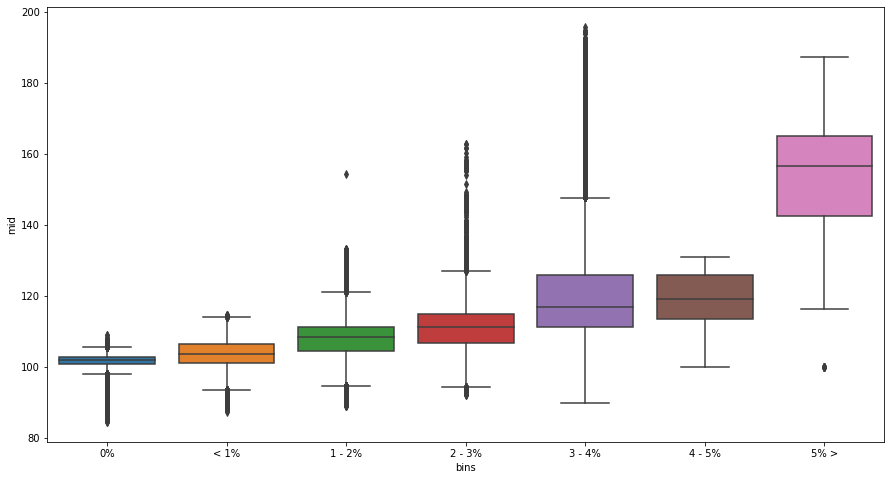

In [236]:
plt.figure(figsize=(15,8))
df_bp =df_bp.assign(bins = pd.cut(df_bp["coupon"], [-1,0.001,1,2,3,4,5,10], 
                        labels=['0%', '< 1%', '1 - 2%','2 - 3%', '3 - 4%','4 - 5%', '5% >']))
sns.boxplot(data = df_bp, x= 'bins', y = 'mid')

We kunnen ook bonds vergelijken met een zelfde resterende looptijd. Het koersverloop wordt dan met name verklaard door het kredietrisico van de issuer en de coupon rente. 

<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

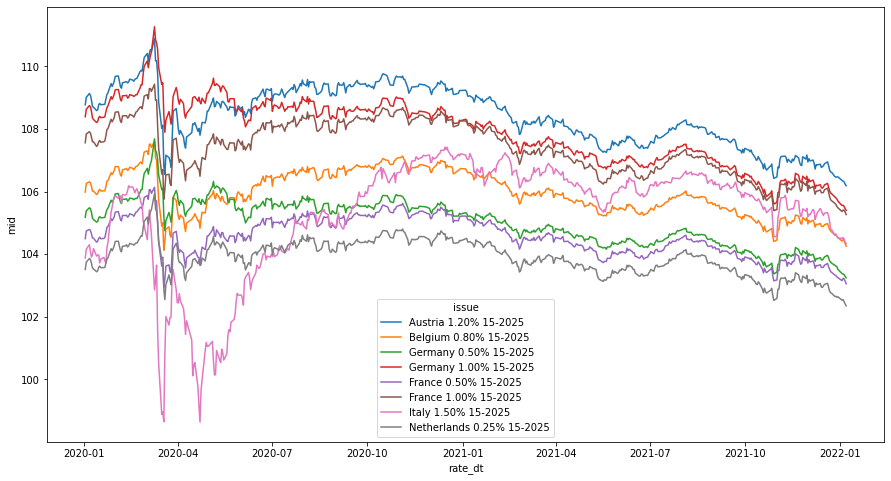

In [237]:

df_mature_2025 = df_bp.loc[( df_bp['mature_dt'].dt.year == 2025 )]
filter =    ( df_mature_2025['coupon'] > 0 ) & \
            ( df_bp_10y['rate_dt'] > '1-jan-2020' )                            
df_mature_2025 = df_mature_2025.loc[filter]
df_mature_2025['issue'] = df_mature_2025['country'] + ' ' + df_mature_2025['bond_ext_name'].str.split(n=1).str[1]
plt.figure(figsize=(15,8))
sns.lineplot(data = df_mature_2025, x = 'rate_dt', y = 'mid', hue = 'issue')

De rating van de bond lijkt niet veel invloed te hebben op de bondprijs.


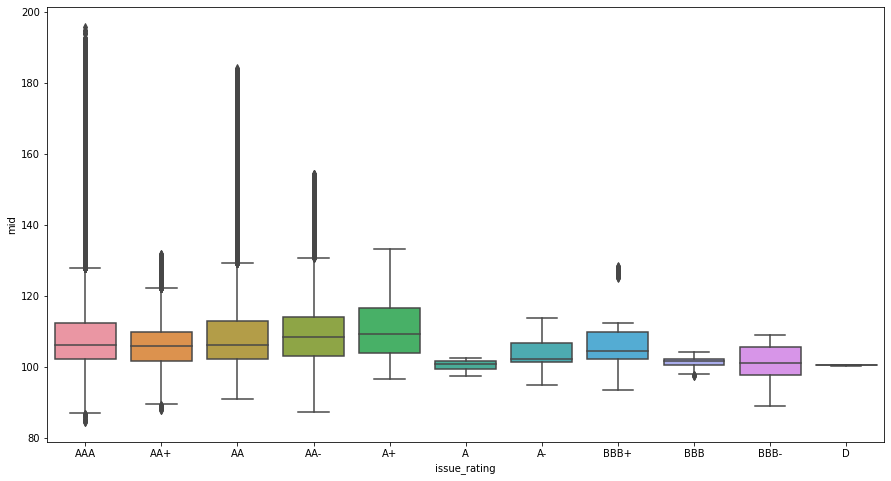

In [238]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data = df_bp, x= 'issue_rating', y = 'mid',
order=["AAA", "AA+","AA","AA-","A+","A","A-","BBB+","BBB","BBB-","D"])



2022-01-16 17:20:56.841 | INFO     | src.data.make_dataset:read_pkl:382 - Load preprocessed yield data


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

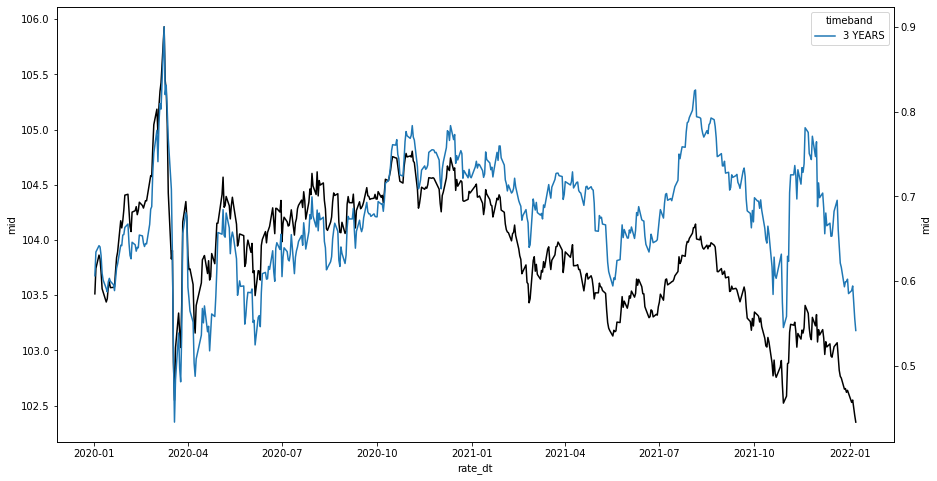

In [250]:
plt.figure(figsize=(15,8))

df_yield = make_dataset.read_pkl('yield')
df_yield = df_yield[df_yield['rate_dt']>='1-jan-2020']
df_yield_nl = df_yield[df_yield['country']=='Netherlands']
df_yield_nl = df_yield_nl[df_yield_nl['timeband'].isin(['3 YEARS'])]

df = df_bp[df_bp['isin'] == "NL0011220108"]
df = df[df['rate_dt'] >= '1-jan-2020']
sns.lineplot(data = df, x = 'rate_dt', y = 'mid',color = 'black')
df_yield_nl['mid'] = df_yield_nl['mid'] * -1
ax2 = plt.twinx()
sns.lineplot(data = df_yield_nl, x = 'rate_dt', y = 'mid', hue = 'timeband', ax=ax2)


In [251]:
df_bonds_i = df_bonds[( df_bonds['country'] == 'Italy' ) & (df_bonds['issue_dt'] <= '1-jan-2018')  & (df_bonds['mature_dt'] >= '1-jan-2022')]
df_bonds_i

,ccy,country,bond_ext_name,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration
24,EUR,Italy,BTPS 1.50% 15-2025,2015-03-02,2015-06-01,2025-06-01,IT0005090318,ITALIE,SEMI ANNUAL,1.50000,19786.72000,DBFUFB,BBB-,3744
84,EUR,Italy,BTPS 1.60% 16-2026,2016-03-01,2016-06-01,2026-06-01,IT0005170839,ITALIE,SEMI ANNUAL,1.60000,16249.50000,DBFUFB,BBB-,3744


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

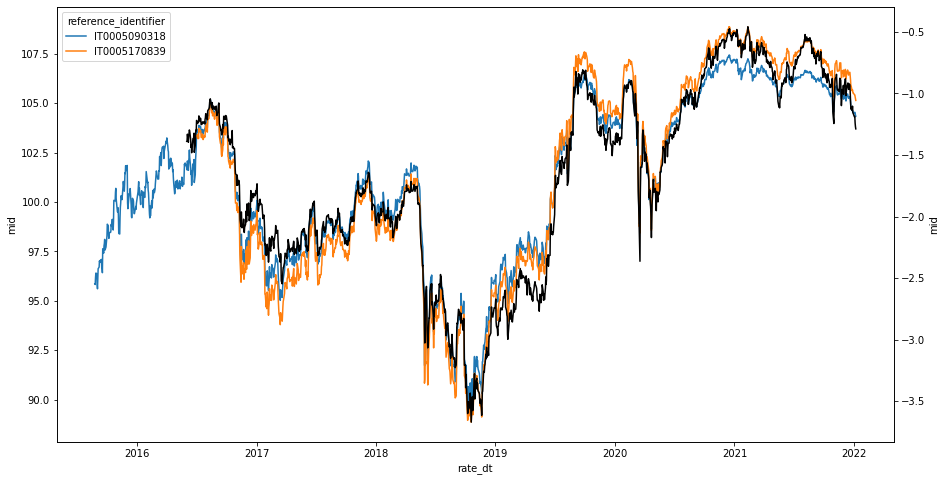

In [13]:
isins = df_bonds_i['isin'].to_list()
df_bp_i = df_bp[df_bp['isin'].isin(isins)]
plt.figure(figsize=(15,8))
sns.lineplot(data = df_bp_i, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

df_y10_italy = df_y10[df_y10['country']=='Italy']
df_y10_italy = df_y10_italy[df_y10_italy['rate_dt'] >= df_bp_i['rate_dt'].min()]
df_y10_italy['mid'] = df_y10_italy['mid'] * -1
ax2 = plt.twinx()
sns.lineplot(data = df_y10_italy, x = 'rate_dt', y = 'mid', color = 'black', ax=ax2)

# Yield Curve

De yield curve wordt samengesteld door de prijzen van government bonds te vergelijken en te projecteren. Een van de features die vanuit de literatuur wordt aangedragen is de 'term spread'. Dit is het verschil tussen korte en lange rente. We zien in onderstaand plaatje dat het verschil in korte en langer rente tot 2019 terug liep.


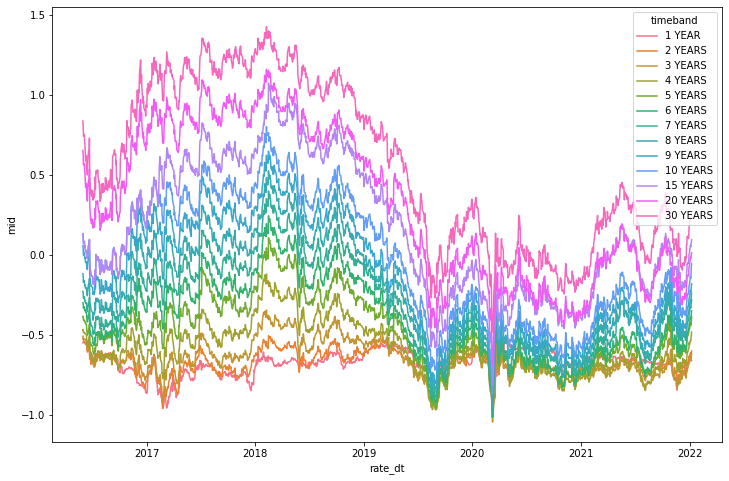

In [17]:
df_yield = make_dataset.read_pkl('yield')
df_yield = df_yield[df_yield['rate_dt'] > '1-jan-2010']

country = 'Germany'
df_country = df_yield[df_yield['country']==country]

plt.figure(figsize=(12, 8))
hue_order = sorted(df_country['timeband'].unique(), key = lambda x: int(x[0:2]))
ax = sns.lineplot(data = df_country, x = 'rate_dt', y = 'mid', hue = 'timeband', hue_order=hue_order)

Credit Spread

Inflation

De rente is theoretisch gecorreleerd aan de inflatie verwachting. In de praktijk is deze correlatie niet altijd evident. Ook is het niet duidelijk of de bondprijzen worden gevormd door de lnflatieverwachting, of omgekeerd de inflatie wordt afgeleid uit stijgende prijzen voor staatsobligaties.

In [27]:
df_inflation['country'].unique()

<StringArray>
['Germany', 'France', 'Spain', 'Italy', 'United States']
Length: 5, dtype: string

2022-01-12 15:25:21.619 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed inflation data


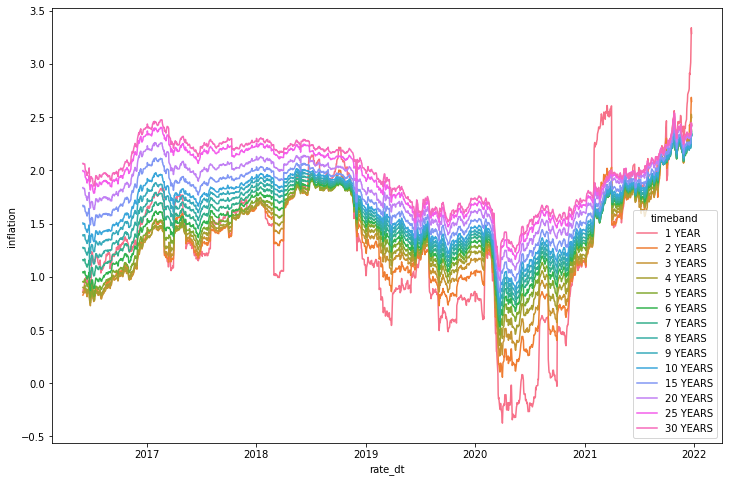

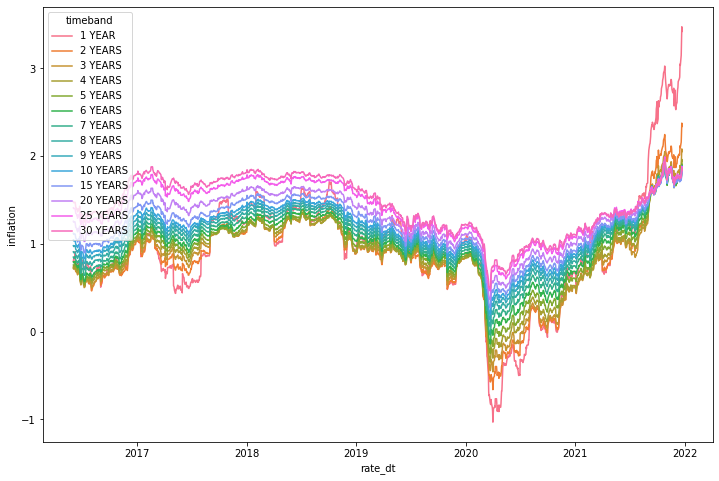

In [29]:

df_inflation = make_dataset.read_pkl('inflation')
df_inflation = df_inflation[df_inflation['rate_dt'] > df_yield['rate_dt'].min()]

country = 'Germany'
df_country = df_inflation[df_inflation['country']==country]

plt.figure(figsize=(12, 8))
hue_order = sorted(df_country['timeband'].unique(), key = lambda x: int(x[0:2]))
ax = sns.lineplot(data = df_country, x = 'rate_dt', y = 'inflation', hue = 'timeband', hue_order=hue_order)

country = 'Italy'
df_country = df_inflation[df_inflation['country']==country]

plt.figure(figsize=(12, 8))
hue_order = sorted(df_country['timeband'].unique(), key = lambda x: int(x[0:2]))
ax = sns.lineplot(data = df_country, x = 'rate_dt', y = 'inflation', hue = 'timeband', hue_order=hue_order)

Inflation should be negatively correlated to the bond price